In [1]:
!pip install openrouteservice folium

In [1]:
import openrouteservice
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"
client = openrouteservice.Client(key=API_KEY)

def get_coordinates(place_name):
    # Function to get coordinates from place name
    result = client.pelias_search(place_name)
    
    if result and "features" in result and len(result["features"]) > 0:
        coords = result["features"][0]["geometry"]["coordinates"]
        return coords[1], coords[0]  # (Latitude, Longitude)
    else:
        return None

# Example Usage
place = "Graphic Era Hill University,Dehradun"
lat, lon = get_coordinates(place)
print(f"Coordinates of {place}: {lat}, {lon}")

Coordinates of Graphic Era Hill University,Dehradun: 30.273002, 78.000246


In [5]:
import folium

def get_distance_time_and_plot(place1: str, place2: str):
    # 2) Geocode both ends
    coords1 = get_coordinates(place1)
    coords2 = get_coordinates(place2)
    if not coords1 or not coords2:
        raise ValueError("One or both locations could not be geocoded.")

    # 3) ORS wants [(lon, lat), (lon, lat)]
    ors_coords = [(coords1[1], coords1[0]), (coords2[1], coords2[0])]

    # 4) Request up to 3 alternative driving routes
    routes = client.directions(
        coordinates=ors_coords,
        profile='driving-car',
        format='geojson',
        optimize_waypoints=True,
        alternative_routes={
            "share_factor": 0.6,   # how different alternatives must be
            "target_count": 3    # number of total routes requested
        }
    )

    # 5) Take the first feature for the “primary” distance/time summary
    primary = routes['features'][0]['properties']['segments'][0]
    distance_km = primary['distance'] / 1000       # km
    duration_min = primary['duration'] / 60        # minutes

    # 6) Create folium map centered on the start
    m = folium.Map(location=coords1, zoom_start=12)
    folium.Marker(coords1, popup=f"Start: {place1}", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(coords2, popup=f"End: {place2}", icon=folium.Icon(color="red")).add_to(m)

    # 7) Plot each alternative route in a different color
    colors = ['blue', 'green', 'red']
    for idx, feat in enumerate(routes['features']):
        geom = feat['geometry']['coordinates']  # list of [lon,lat]
        # flip to [(lat, lon), ...]
        latlons = [(lat, lon) for lon, lat in geom]
        folium.PolyLine(
            latlons,
            color=colors[idx % len(colors)],
            weight=4,
            opacity=0.7,
            tooltip=(
                f"Route {idx+1}: "
                f"{feat['properties']['summary']['distance']/1000:.1f} km, "
                f"{feat['properties']['summary']['duration']/60:.0f} min"
            )
        ).add_to(m)

    # 8) Print summary and return map
    print(f"Route {idx+1}: Distance = {distance_km:.2f} km, Estimated Time = {duration_min:.1f} min")
    return m

# Example usage:
place1 = "Marina Hostel, Graphic Era Hill University, Dehradun"
place2 = "Paltan Bazar, Dehradun"
map_result = get_distance_time_and_plot(place1, place2)
map_result  # in Jupyter this will render; in scripts use map_result.save("map.html")

Route 3: Distance = 11.81 km, Estimated Time = 14.0 min


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Optimal number of clusters (k): 2


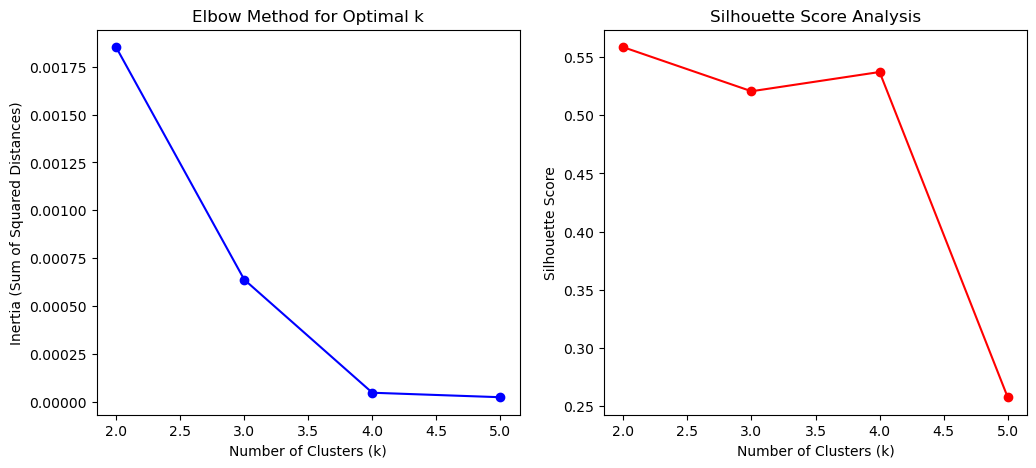

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Example delivery locations (Replace with actual locations from your dataset)
locations = [
    "Rajpur Road, Dehradun",
    "ISBT, Dehradun",
    "Paltan Bazar, Dehradun",
    "Graphic Era Deemed to be University, Dehradun",
    "Prem Nagar, Dehradun",
    "Graphic Era Hill University, Dehradun"
]

# Convert place names to coordinates
coords_array = np.array([get_coordinates(loc) for loc in locations])  # Convert locations to coordinates

# Ensure k < number of locations
K_range = range(2, min(len(coords_array), 7))  # Adjusted range

inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(coords_array)
    
    inertia.append(kmeans.inertia_)  # Inertia
    if k < len(coords_array):  # Avoid silhouette error
        silhouette_scores.append(silhouette_score(coords_array, cluster_labels))
    else:
        silhouette_scores.append(None)  # Placeholder for invalid k

# Find the best k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]  # Selecting k with the highest Silhouette Score
print(f"Optimal number of clusters (k): {optimal_k}")


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


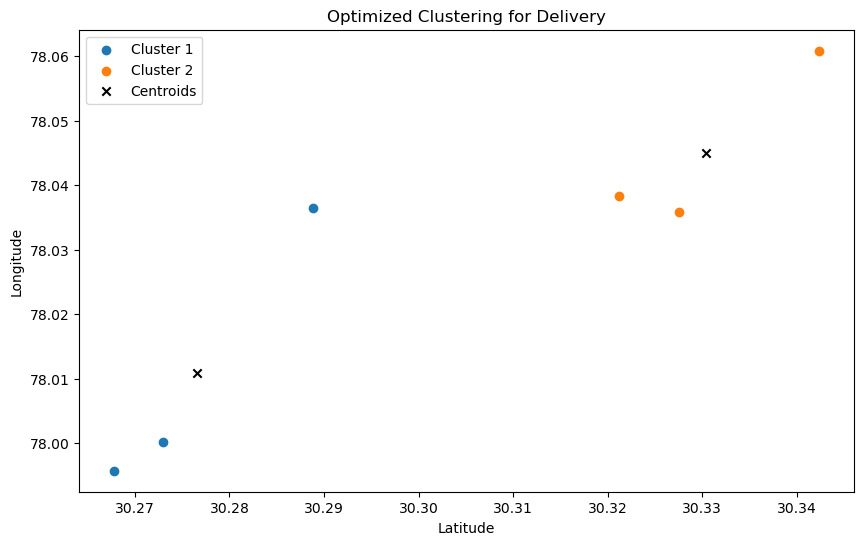

In [9]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(coords_array)

# Assign vehicles (1 vehicle per cluster)
vehicle_assignments = {i: [] for i in range(optimal_k)}
for i, label in enumerate(cluster_labels):
    vehicle_assignments[label].append(coords_array[i])  # Assign location to a vehicle

# Convert dictionary to a list for easy processing
vehicles_clusters = [np.array(vehicle_assignments[i]) for i in range(optimal_k)]


In [11]:
# Initialize map centered at Dehradun
map_center = [np.mean(coords_array[:, 0]), np.mean(coords_array[:, 1])]
m = folium.Map(location=map_center, zoom_start=13)

# Define cluster colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige']

# Plot locations on the map
for i, (lat, lon) in enumerate(coords_array):
    cluster_id = cluster_labels[i]
    place_name = locations[i]  # Get the place name
    popup_text = f"{place_name} (Cluster {cluster_id + 1})"
    
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=colors[cluster_id % len(colors)])
    ).add_to(m)

# Plot cluster centroids
for i, (lat, lon) in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        location=[lat, lon],
        popup=f"Centroid {i + 1}",
        icon=folium.Icon(color='black', icon='cloud')
    ).add_to(m)

# Display the map
m

In [ ]:
import heapq
from math import radians, cos, sin, sqrt, atan2

# Sample city coordinates (latitude, longitude)
locations = {
    'New York': (40.71427, -74.00597),
    'Hartford': (41.76371, -72.68509),
    'Boston': (42.36008, -71.05888),
    'Albany': (42.65258, -73.75623)
}

# Graph: Neighbors and distances (in km, approx)
graph = {
    'New York': {'Hartford': 190, 'Albany': 240},
    'Hartford': {'Boston': 160, 'New York': 190},
    'Boston': {'Hartford': 160},
    'Albany': {'New York': 240, 'Boston': 270}
}

# Haversine distance (heuristic)
def haversine(coord1, coord2):
    R = 6371  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# A* Algorithm
def astar(start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {city: float('inf') for city in graph}
    g_score[start] = 0
    f_score = {city: float('inf') for city in graph}
    f_score[start] = haversine(locations[start], locations[goal])

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], g_score[goal]

        for neighbor, dist in graph[current].items():
            tentative_g = g_score[current] + dist
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + haversine(locations[neighbor], locations[goal])
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None, float('inf')

# Run A* from New York to Boston
path, total_distance = astar('New York', 'Boston')
print("A* Path:", path)
print("Total Distance:", total_distance, "km")


In [2]:
import openrouteservice
from openrouteservice.optimization import Vehicle, Job

# ORS API Key
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"

# Initialize ORS client
client = openrouteservice.Client(key=API_KEY)

# Coordinates (longitude, latitude)
locations = [
    [77.2090, 28.6139],  # Delhi (Depot)
    [75.7873, 26.9124],  # Jaipur
    [78.0081, 27.1767],  # Agra
    [78.1642, 29.9457],  # Haridwar
]

# Create jobs (excluding depot at index 0)
jobs = [
    Job(id=i, location=loc)
    for i, loc in enumerate(locations[1:], start=1)
]

# Define the vehicle (starting and ending at the depot)
vehicle = Vehicle(
    id=0,
    start=locations[0],
    end=locations[0]
)

# Now call the optimization API
try:
    result = client.optimization(
        jobs=jobs,
        vehicles=[vehicle]
    )

    print("📍 Optimized TSP Route:")
    for step in result['routes'][0]['steps']:
        step_type = step.get("type")
        if step_type == "start":
            print(f"Start at depot: {locations[0]}")
        elif step_type == "job":
            job_id = step['job']
            print(f"Visit: {locations[job_id]}")
        elif step_type == "end":
            print(f"Return to depot: {locations[0]}")
except Exception as e:
    import traceback
    print("❌ Error occurred:")
    traceback.print_exc()


📍 Optimized TSP Route:
Start at depot: [77.209, 28.6139]
Visit: [75.7873, 26.9124]
Visit: [78.0081, 27.1767]
Visit: [78.1642, 29.9457]
Return to depot: [77.209, 28.6139]


In [2]:
import openrouteservice

# Replace with your ORS API key
client = openrouteservice.Client(key='5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2')

# Coordinates: [lon, lat]
depot = [8.681495, 49.41461]  # Heidelberg
jobs = [
    {"id": 1, "location": [8.687872, 49.420318]},
    {"id": 2, "location": [8.68416, 49.40618]},
    {"id": 3, "location": [8.675634, 49.412158]},
    {"id": 4, "location": [8.67387, 49.41956]}
]

# Define vehicles (start and end at depot)
vehicles = [{
    "id": 1,
    "start": depot,
    "end": depot
}, {
    "id": 2,
    "start": depot,
    "end": depot
}]

# Send VRP request
vrp_result = client.optimization(
    jobs=jobs,
    vehicles=vehicles
)

# Print out solution
for route in vrp_result['routes']:
    print(f"Vehicle {route['vehicle']}:")
    for step in route['steps']:
        if 'job' in step:
            print(f"  → Job {step['job']} at {step['location']}")
    print(f"  Total Distance: {route['distance']} meters")
    print(f"  Total Duration: {route['duration']} seconds")


AssertionError: 

C:\Users\asus\anaconda3\Lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)
C:\Users\asus\anaconda3\Lib\site-packages\openrouteservice\client.py:195: UserWarning: Server down.
Retrying for the 1st time.
  warnings.warn('Server down.\nRetrying for the {0}{1} time.'.format(retry_counter + 1,
C:\Users\asus\anaconda3\Lib\site-packages\openrouteservice\client.py:195: UserWarning: Server down.
Retrying for the 2nd time.
  warnings.warn('Server down.\nRetrying for the {0}{1} time.'.format(retry_counter + 1,
C:\Users\asus\anaconda3\Lib\site-packages\openrouteservice\client.py:195: UserWarning: Server down.
Retrying for the 3rd time.
  warnings.warn('Server down.\nRetrying for the {0}{1} time.'.format(retry_counter + 1,


Primary Route: Distance = 11.81 km, Time = 14.0 min


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Optimal k: 2


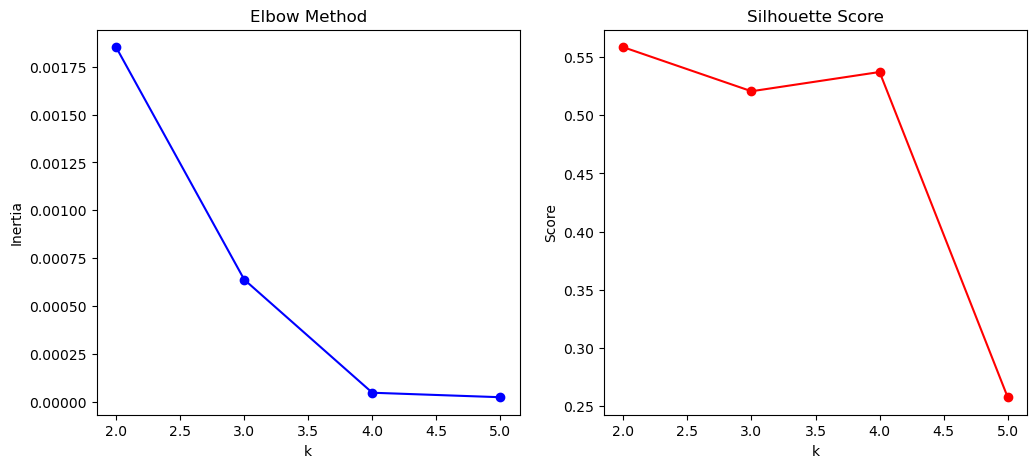

C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


A* Path: ['New York', 'Hartford', 'Boston'] Total Distance: 350
📍 Optimized Route:
Start at depot: [77.209, 28.6139]
Visit job 1: [75.7873, 26.9124]
Visit job 2: [78.0081, 27.1767]
Visit job 3: [78.1642, 29.9457]
Return to depot: [77.209, 28.6139]


In [4]:
import openrouteservice
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import heapq
from math import radians, cos, sin, sqrt, atan2

# Initialize OpenRouteService client
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"
client = openrouteservice.Client(key=API_KEY)

# ----------------------------------------
# 1. Geocoding Function
# ----------------------------------------
def get_coordinates(place_name):
    result = client.pelias_search(place_name)
    if result and "features" in result and result["features"]:
        coords = result["features"][0]["geometry"]["coordinates"]
        return coords[1], coords[0]  # (lat, lon)
    return None

# ----------------------------------------
# 2. Route Plotting Function
# ----------------------------------------
def get_distance_time_and_plot(place1: str, place2: str):
    coords1 = get_coordinates(place1)
    coords2 = get_coordinates(place2)
    if not coords1 or not coords2:
        raise ValueError("One or both locations could not be geocoded.")

    ors_coords = [(coords1[1], coords1[0]), (coords2[1], coords2[0])]
    routes = client.directions(
        coordinates=ors_coords,
        profile='driving-car',
        format='geojson',
        optimize_waypoints=True,
        alternative_routes={"share_factor": 0.6, "target_count": 3}
    )

    m = folium.Map(location=coords1, zoom_start=12)
    folium.Marker(coords1, popup=f"Start: {place1}", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(coords2, popup=f"End: {place2}", icon=folium.Icon(color="red")).add_to(m)

    colors = ['blue', 'green', 'red']
    for idx, feat in enumerate(routes['features']):
        geom = feat['geometry']['coordinates']
        latlons = [(lat, lon) for lon, lat in geom]
        folium.PolyLine(
            latlons,
            color=colors[idx % len(colors)],
            weight=4,
            opacity=0.7,
            tooltip=(
                f"Route {idx+1}: "
                f"{feat['properties']['summary']['distance']/1000:.1f} km, "
                f"{feat['properties']['summary']['duration']/60:.0f} min"
            )
        ).add_to(m)

    primary = routes['features'][0]['properties']['segments'][0]
    print(f"Primary Route: Distance = {primary['distance']/1000:.2f} km, "
          f"Time = {primary['duration']/60:.1f} min")

    return m

# ----------------------------------------
# 3. Clustering and Vehicle Assignment
# ----------------------------------------
def cluster_delivery_points(locations):
    coords_array = np.array([get_coordinates(loc) for loc in locations if get_coordinates(loc)])

    K_range = range(2, min(len(coords_array), 7))
    inertia, silhouette_scores = [], []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(coords_array)
        inertia.append(kmeans.inertia_)
        if k < len(coords_array):
            silhouette_scores.append(silhouette_score(coords_array, labels))
        else:
            silhouette_scores.append(None)

    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal k: {optimal_k}")

    # Plotting elbow and silhouette
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, inertia, 'bo-')
    plt.title('Elbow Method')
    plt.xlabel('k'), plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot([k for k in K_range if silhouette_scores[k - 2] is not None],
             [score for score in silhouette_scores if score is not None], 'ro-')
    plt.title('Silhouette Score')
    plt.xlabel('k'), plt.ylabel('Score')
    plt.show()

    # Final Clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(coords_array)

    m = folium.Map(location=[np.mean(coords_array[:, 0]), np.mean(coords_array[:, 1])], zoom_start=13)
    cluster_colors = ['red', 'blue', 'green', 'purple', 'orange']

    for i, (lat, lon) in enumerate(coords_array):
        folium.Marker([lat, lon], icon=folium.Icon(color=cluster_colors[labels[i] % len(cluster_colors)]),
                      popup=f"{locations[i]} (Cluster {labels[i]+1})").add_to(m)

    for i, (lat, lon) in enumerate(kmeans.cluster_centers_):
        folium.Marker([lat, lon], icon=folium.Icon(color="black", icon="cloud"), popup=f"Centroid {i+1}").add_to(m)

    return m

# ----------------------------------------
# 4. A* Pathfinding Algorithm
# ----------------------------------------
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

def astar(graph, locations, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {city: float('inf') for city in graph}
    g_score[start] = 0
    f_score = {city: float('inf') for city in graph}
    f_score[start] = haversine(locations[start], locations[goal])

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], g_score[goal]

        for neighbor, dist in graph[current].items():
            tentative_g = g_score[current] + dist
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + haversine(locations[neighbor], locations[goal])
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None, float('inf')

# ----------------------------------------
# 5. Vehicle Routing Problem using ORS Optimization API
# ----------------------------------------
from openrouteservice.optimization import Vehicle, Job

def solve_vrp(coords, depot_index=0):
    depot = coords[depot_index]
    jobs = [Job(id=i, location=loc) for i, loc in enumerate(coords) if i != depot_index]
    vehicle = Vehicle(id=0, start=depot, end=depot)

    try:
        result = client.optimization(jobs=jobs, vehicles=[vehicle])
        steps = result['routes'][0]['steps']
        print("📍 Optimized Route:")
        for step in steps:
            if step['type'] == "start":
                print(f"Start at depot: {step['location']}")
            elif step['type'] == "job":
                print(f"Visit job {step['job']}: {step['location']}")
            elif step['type'] == "end":
                print(f"Return to depot: {step['location']}")

        # Extract coordinates of route
        ordered_coords = [step['location'] for step in steps]

        # Get full route geometry from ORS
        full_route = client.directions(
            coordinates=ordered_coords,
            profile='driving-car',
            format='geojson'
        )

        # Map creation
        m = folium.Map(location=[depot[1], depot[0]], zoom_start=6)

        # Plot route
        folium.GeoJson(full_route, name="Optimized Route").add_to(m)

        # Mark points
        for idx, loc in enumerate(ordered_coords):
            popup = "Depot" if idx == 0 or idx == len(ordered_coords)-1 else f"Job {idx}"
            color = "green" if idx == 0 else ("red" if idx == len(ordered_coords)-1 else "blue")
            folium.Marker([loc[1], loc[0]], popup=popup, icon=folium.Icon(color=color)).add_to(m)

        return m

    except Exception as e:
        print("❌ VRP Error:", e)


# ----------------------------------------
# Example Usage
# ----------------------------------------

# Route plotting
get_distance_time_and_plot("Marina Hostel, Graphic Era Hill University, Dehradun", "Paltan Bazar, Dehradun")

# Clustering
delivery_places = [
    "Rajpur Road, Dehradun",
    "ISBT, Dehradun",
    "Paltan Bazar, Dehradun",
    "Graphic Era Deemed to be University, Dehradun",
    "Prem Nagar, Dehradun",
    "Graphic Era Hill University, Dehradun"
]
cluster_delivery_points(delivery_places)

# A* Example
cities = {
    'New York': (40.71427, -74.00597),
    'Hartford': (41.76371, -72.68509),
    'Boston': (42.36008, -71.05888),
    'Albany': (42.65258, -73.75623)
}
city_graph = {
    'New York': {'Hartford': 190, 'Albany': 240},
    'Hartford': {'Boston': 160, 'New York': 190},
    'Boston': {'Hartford': 160},
    'Albany': {'New York': 240, 'Boston': 270}
}
path, dist = astar(city_graph, cities, 'New York', 'Boston')
print("A* Path:", path, "Total Distance:", dist)

# VRP Optimization
tsp_coords = [
    [77.2090, 28.6139],  # Depot (Delhi)
    [75.7873, 26.9124],  # Jaipur
    [78.0081, 27.1767],  # Agra
    [78.1642, 29.9457]   # Haridwar
]
solve_vrp(tsp_coords)


In [5]:
import os
import osmnx as ox
import networkx as nx
import pickle
import openrouteservice
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import heapq
from math import radians, cos, sin, sqrt, atan2

# Initialize OpenRouteService client
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"
client = openrouteservice.Client(key=API_KEY)

# ----------------------------------------
# 1. Geocoding Function
# ----------------------------------------
def get_coordinates(place_name):
    result = client.pelias_search(place_name)
    if result and "features" in result and result["features"]:
        coords = result["features"][0]["geometry"]["coordinates"]
        return coords[1], coords[0]  # (lat, lon)
    return None

# Example delivery locations (Replace with actual locations from your dataset)
locations = [
    "Rajpur Road, Dehradun",
    "ISBT, Dehradun",
    "Paltan Bazar, Dehradun",
    "Graphic Era Deemed to be University, Dehradun",
    "Prem Nagar, Dehradun",
    "Graphic Era Hill University, Dehradun"
]

# Convert place names to coordinates
coords_array = np.array([get_coordinates(loc) for loc in locations])  # Convert locations to coordinates

# Ensure k < number of locations
K_range = range(2, min(len(coords_array), 7))  # Adjusted range

inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(coords_array)
    
    inertia.append(kmeans.inertia_)  # Inertia
    if k < len(coords_array):  # Avoid silhouette error
        silhouette_scores.append(silhouette_score(coords_array, cluster_labels))
    else:
        silhouette_scores.append(None)  # Placeholder for invalid k

# Find the best k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]  # Selecting k with the highest Silhouette Score
print(f"Optimal number of clusters (k): {optimal_k}")
import pandas as pd

# Assuming you already have cluster_labels from KMeans
# Combine original data into a DataFrame
clustered_data = pd.DataFrame({
    'Location': locations,
    'Latitude': coords_array[:, 0],
    'Longitude': coords_array[:, 1],
    'Cluster': cluster_labels
})

# Save to CSV
clustered_data.to_csv('clustered_locations.csv', index=False)

print("✅ Clustered data saved to 'clustered_locations.csv'")



Optimal number of clusters (k): 2
✅ Clustered data saved to 'clustered_locations.csv'


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

In [9]:
import pandas as pd

# Load all clustered data (if already saved)
clustered_data = pd.read_csv("clustered_locations.csv")

# Select one cluster (e.g., cluster 0)
cluster_id = 0  # You can loop through or choose based on optimization needs
cluster_points = clustered_data[clustered_data['Cluster'] == cluster_id]

# Convert to list of (lat, lon) tuples
cluster_coords = list(zip(cluster_points['Latitude'], cluster_points['Longitude']))



In [11]:
# ------------------------------
# CONFIGURATION
# ------------------------------

GRAPH_FILE = "dehradun.graphml"
GEOCACHE_FILE = "geocache.pkl"
SHOW_MAP = True  # Set False if just calculating route

# ------------------------------
# 1. Load or Download Graph
# ------------------------------

def load_graph():
    if os.path.exists(GRAPH_FILE):
        print("✅ Loading graph from file...")
        return ox.load_graphml(GRAPH_FILE)
    else:
        print("⏳ Downloading Dehradun map...")
        G = ox.graph_from_place("Dehradun, India", network_type='drive')
        #G = ox.simplify_graph(G)
        ox.save_graphml(G, GRAPH_FILE)
        return G

# ------------------------------
# 2. Cached Geocoding
# ------------------------------

def cached_geocode(place):
    if os.path.exists(GEOCACHE_FILE):
        with open(GEOCACHE_FILE, "rb") as f:
            cache = pickle.load(f)
    else:
        cache = {}

    if place in cache:
        return cache[place]
    else:
        coord = ox.geocode(place)
        cache[place] = coord
        with open(GEOCACHE_FILE, "wb") as f:
            pickle.dump(cache, f)
        return coord

# ------------------------------
# 3. Haversine A* Heuristic
# ------------------------------

def haversine_heuristic(u, v, G):
    lat1, lon1 = G.nodes[u]['y'], G.nodes[u]['x']
    lat2, lon2 = G.nodes[v]['y'], G.nodes[v]['x']
    R = 6371  # Earth radius (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c * 1000  # return in meters

# ------------------------------
# 4. Main Route Logic
# ------------------------------

def find_and_display_route(start, end):
    G = load_graph()

    start_point = cached_geocode(start)
    end_point = cached_geocode(end)

    orig_node = ox.nearest_nodes(G, X=start_point[1], Y=start_point[0])
    dest_node = ox.nearest_nodes(G, X=end_point[1], Y=end_point[0])

    # Routes
    dijkstra_path = nx.shortest_path(G, orig_node, dest_node, weight='length')
    astar_path = nx.astar_path(G, orig_node, dest_node,
                               heuristic=lambda u, v: haversine_heuristic(u, v, G),
                               weight='length')

    print(f"✅ Dijkstra path length: {nx.path_weight(G, dijkstra_path, weight='length'):.2f} meters")
    print(f"✅ A* path length:       {nx.path_weight(G, astar_path, weight='length'):.2f} meters")

    if SHOW_MAP:
        dijkstra_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in dijkstra_path]
        astar_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in astar_path]
        map_center = [(start_point[0] + end_point[0]) / 2, (start_point[1] + end_point[1]) / 2]

        m = folium.Map(location=map_center, zoom_start=13)
        folium.PolyLine(dijkstra_coords, color='blue', weight=4, opacity=0.7, tooltip='Dijkstra Path').add_to(m)
        folium.PolyLine(astar_coords, color='green', weight=4, opacity=0.7, tooltip='A* Path').add_to(m)
        folium.Marker(start_point, popup=f'Start: {start}', icon=folium.Icon(color='red')).add_to(m)
        folium.Marker(end_point, popup=f'End: {end}', icon=folium.Icon(color='purple')).add_to(m)

        # map_file = "route_comparison_map.html"
        # m.save(map_file)
        # print(f"🗺️ Map saved as '{map_file}'")
        return m

# ------------------------------
# 5. Example Usage
# ------------------------------

for i in range(len(cluster_coords) - 1):
    start = cluster_coords[i]
    end = cluster_coords[i + 1]

    # Convert coordinates back to address using reverse geocoding (optional)
    # Or modify your A* function to accept lat/lon directly
    find_and_display_route(start, end)

✅ Loading graph from file...


InsufficientResponseError: Nominatim could not geocode query (30.321195, 78.038291).

In [1]:
import pandas as pd
import numpy as np
import folium
from math import radians, cos, sin, sqrt, atan2

# ----------------------------------------
# Haversine Distance (meters)
# ----------------------------------------
def haversine(coord1, coord2):
    R = 6371000
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# ----------------------------------------
# Load CSV and Extract Coordinates
# ----------------------------------------
def load_locations(csv_file):
    df = pd.read_csv(csv_file)
    coords = df[['Latitude', 'Longitude']].values
    return df['Location'].tolist(), coords

# ----------------------------------------
# TSP Nearest Neighbor
# ----------------------------------------
def tsp_nearest_neighbor(locations, coords):
    centroid = np.mean(coords, axis=0)
    start_index = np.argmin([haversine(centroid, c) for c in coords])

    visited = [start_index]
    current_index = start_index

    while len(visited) < len(coords):
        nearest = None
        min_dist = float('inf')
        for i in range(len(coords)):
            if i not in visited:
                dist = haversine(coords[current_index], coords[i])
                if dist < min_dist:
                    nearest = i
                    min_dist = dist
        visited.append(nearest)
        current_index = nearest

    return visited

# ----------------------------------------
# Plot Route on Folium Map
# ----------------------------------------
def plot_tsp_route(locations, coords, order):
    start_coord = coords[order[0]]
    m = folium.Map(location=start_coord, zoom_start=13)

    # Add markers and route lines
    for idx, i in enumerate(order):
        folium.Marker(
            location=coords[i],
            popup=f"{idx+1}. {locations[i]}",
            icon=folium.Icon(color='blue' if idx > 0 else 'red')
        ).add_to(m)

    # Add route lines
    route = [coords[i] for i in order]
    folium.PolyLine(route, color='green', weight=4, tooltip="TSP Route").add_to(m)

    return m

# ----------------------------------------
# Main Function
# ----------------------------------------
def run_tsp_with_map(csv_file):
    locations, coords = load_locations(csv_file)
    order = tsp_nearest_neighbor(locations, coords)

    print("📍 TSP Visit Order:")
    for i in order:
        print(f"➡ {locations[i]}")

    # Save ordered route
    ordered_df = pd.DataFrame({
        'VisitOrder': list(range(1, len(order)+1)),
        'Location': [locations[i] for i in order],
        'Latitude': [coords[i][0] for i in order],
        'Longitude': [coords[i][1] for i in order]
    })
    ordered_df.to_csv("tsp_route.csv", index=False)
    print("\n✅ Route saved to 'tsp_route.csv'")

    # Show Map
    return plot_tsp_route(locations, coords, order)

# ----------------------------------------
# Example Usage
# ----------------------------------------
map_object = run_tsp_with_map("clustered_locations.csv")  # Replace with your CSV file
map_object  # Display map in notebook


📍 TSP Visit Order:
➡ ISBT, Dehradun
➡ Paltan Bazar, Dehradun
➡ Prem Nagar, Dehradun
➡ Rajpur Road, Dehradun
➡ Graphic Era Hill University, Dehradun
➡ Graphic Era Deemed to be University, Dehradun

✅ Route saved to 'tsp_route.csv'


In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import folium
from math import radians, cos, sin, sqrt, atan2

# ------------------------------
# CONFIGURATION
# ------------------------------
GRAPH_FILE = "dehradun.graphml"
GEOCACHE_FILE = "geocache.pkl"

# ------------------------------
# 1. Load Graph from File or OSM
# ------------------------------
def load_graph():
    if os.path.exists(GRAPH_FILE):
        print("✅ Loading graph from file...")
        return ox.load_graphml(GRAPH_FILE)
    else:
        print("⏳ Downloading Dehradun map...")
        G = ox.graph_from_place("Dehradun, India", network_type='drive')
        ox.save_graphml(G, GRAPH_FILE)
        return G

# ------------------------------
# 2. Haversine Distance (meters)
# ------------------------------
def haversine(coord1, coord2):
    R = 6371000
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# ------------------------------
# 3. Haversine Heuristic for A*
# ------------------------------
def haversine_heuristic(u, v, G):
    lat1, lon1 = G.nodes[u]['y'], G.nodes[u]['x']
    lat2, lon2 = G.nodes[v]['y'], G.nodes[v]['x']
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lat2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c * 1000

# ------------------------------
# 4. Load CSV and Extract Coordinates
# ------------------------------
def load_locations(csv_file):
    df = pd.read_csv(csv_file)
    coords = df[['Latitude', 'Longitude']].values
    return df['Location'].tolist(), coords

# ------------------------------
# 5. TSP Nearest Neighbor Heuristic
# ------------------------------
def tsp_nearest_neighbor(locations, coords):
    centroid = np.mean(coords, axis=0)
    start_index = np.argmin([haversine(centroid, c) for c in coords])

    visited = [start_index]
    current_index = start_index

    while len(visited) < len(coords):
        nearest = None
        min_dist = float('inf')
        for i in range(len(coords)):
            if i not in visited:
                dist = haversine(coords[current_index], coords[i])
                if dist < min_dist:
                    nearest = i
                    min_dist = dist
        visited.append(nearest)
        current_index = nearest

    return visited

# ------------------------------
# 6. Plot A* Paths Between TSP Nodes
# ------------------------------
def plot_astar_route_from_coords(coords, order):
    G = load_graph()
    m = folium.Map(location=coords[order[0]], zoom_start=13)

    for idx in range(len(order) - 1):
        start_coord = coords[order[idx]]
        end_coord = coords[order[idx + 1]]

        start_node = ox.nearest_nodes(G, X=start_coord[1], Y=start_coord[0])
        end_node = ox.nearest_nodes(G, X=end_coord[1], Y=end_coord[0])

        astar_path = nx.astar_path(G, start_node, end_node,
                                   heuristic=lambda u, v: haversine_heuristic(u, v, G),
                                   weight='length')

        path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in astar_path]
        folium.PolyLine(path_coords, color='green', weight=4, opacity=0.7,
                        tooltip=f"A* Segment {idx+1}").add_to(m)

    # Add markers
    for idx, i in enumerate(order):
        folium.Marker(
            location=coords[i],
            popup=f"{idx+1}.",
            icon=folium.Icon(color='blue' if idx > 0 else 'red')
        ).add_to(m)

    return m

# ------------------------------
# 7. Main Execution Function
# ------------------------------
def run_tsp_with_map(csv_file):
    locations, coords = load_locations(csv_file)
    order = tsp_nearest_neighbor(locations, coords)

    print("📍 TSP Visit Order:")
    for i in order:
        print(f"➡ {locations[i]}")

    # Save ordered route
    ordered_df = pd.DataFrame({
        'VisitOrder': list(range(1, len(order)+1)),
        'Location': [locations[i] for i in order],
        'Latitude': [coords[i][0] for i in order],
        'Longitude': [coords[i][1] for i in order]
    })
    ordered_df.to_csv("tsp_route.csv", index=False)
    print("\n✅ Route saved to 'tsp_route.csv'")

    # Show A* map using OSM
    return plot_astar_route_from_coords(coords, order)

# ------------------------------
# 8. Run It
# ------------------------------
if __name__ == "__main__":
    map_object = run_tsp_with_map("clustered_locations.csv")
    map_object.save("tsp_astar_map.html")
    print("🗺️ Map saved as 'tsp_astar_map.html'")


📍 TSP Visit Order:
➡ ISBT, Dehradun
➡ Paltan Bazar, Dehradun
➡ Prem Nagar, Dehradun
➡ Rajpur Road, Dehradun
➡ Graphic Era Hill University, Dehradun
➡ Graphic Era Deemed to be University, Dehradun

✅ Route saved to 'tsp_route.csv'
✅ Loading graph from file...
🗺️ Map saved as 'tsp_astar_map.html'
